# Azure OpenAI_DallE2_Generating_Image.ipynb

# Packages & Credentials

In [1]:
import requests
import json
from PIL import Image
import logging
from openai import cli
import matplotlib.pyplot as plt
import requests
import os
import time
import azure.ai.vision as visionsdk
import openai
from io import BytesIO

In [5]:

openai.api_type = 'azure'
openai.api_base = os.environ.get('openai.api_base')
openai.api_version = os.environ.get('openai.api_version')
openai.api_key = os.environ.get('openai.api_key')
vision_base= os.environ.get('cognitive_endpoint')
vision_key= os.environ.get('cognitive_key')

# Function

In [3]:
def get_image(prompt):
    api_version = '2022-08-03-preview'
    url = "{}dalle/text-to-image?api-version={}".format(openai.api_base, api_version)
    headers = {"api-key": openai.api_key, "Content-Type": "application/json"}
    body = {
        "caption": prompt,
        "resolution": "512x512"
    }

    max_tries = 8
    tries = 0
    total_wait = 30
    time_waited = 0

    while tries < max_tries and time_waited < total_wait:
        submission = requests.post(url, headers=headers, json=body)
        if submission.status_code != 202:
            retry_after = int(submission.headers.get('Retry-After', 0))
            time.sleep(retry_after+2)
            logging.info("failed: DallE2 Request failed. retry")
            print("failed: DallE2 Request failed. retry")
            continue
        else:
            try:
                operation_location = submission.headers['Operation-Location']
            except KeyError:
                logging.info("failed: Operation-Location header missing!!!")
                print("failed: Operation-Location header missing!!!")
                time.sleep(1)
                continue
            
            start_time = time.time()
            while time.time() - start_time < total_wait - time_waited:
                response = requests.get(operation_location, headers=headers)
                if response.status_code == 200:
                    status = response.json()['status']
                    if status == "Succeeded":
                        logging.info("succeeded...")
                        print("succeeded...")
                        return response.json()['result']['contentUrl']
                    elif status == "Running":
                        retry_after = int(response.headers.get('Retry-After', 0))
                        time.sleep(retry_after)
                    else:
                        logging.info("failed: status = " + status)
                        print("failed: status = " + status)
                        break
                else:
                    logging.info("failed: response code = " + str(response.status_code))
                    print("failed: response code = " + str(response.status_code))
                    time.sleep(1)
                    break
                time_waited = time.time() - start_time
                tries += 1
            if status == "Succeeded":
                break
            else:
                tries += 1
    return None

# Prompt and Run

succeeded...


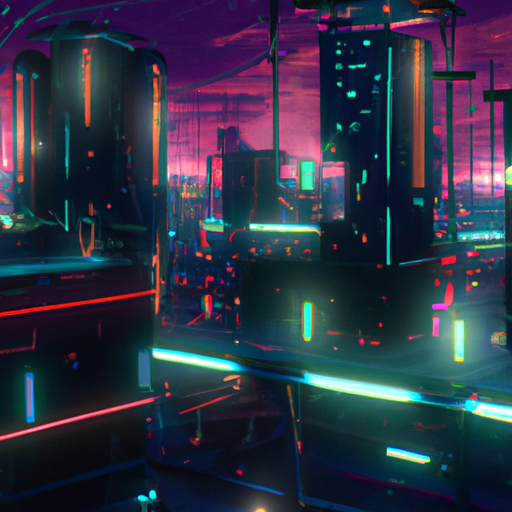

In [4]:
prompt = "a metropolitan city, Cyberpunk, Long shot"
result= get_image(prompt)
response = requests.get(result)

# Load the image data from the response content
img_data = response.content

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

display(img)